In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement

Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [ ]:
# Find the most recent date in the data set.

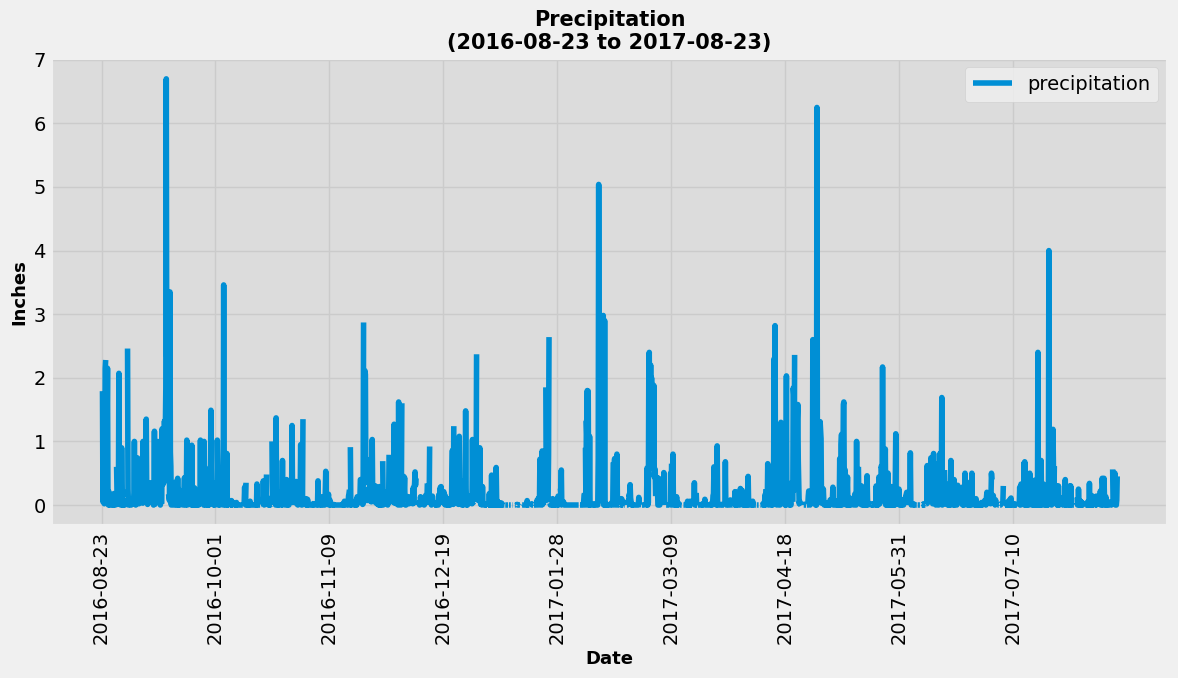

In [23]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_date_query = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date_str = last_date_query[0]
last_date = dt.datetime.strptime(last_date_str, '%Y-%m-%d').date()

yr_ago_date = last_date - dt.timedelta(days=365)
yr_ago_date_str = yr_ago_date.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
prcp_12m = session.query(Measurement.date, Measurement.prcp)\
                    .filter(Measurement.date <= last_date_str)\
                    .filter(Measurement.date >= yr_ago_date_str).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_12m_df = pd.DataFrame(prcp_12m, columns=['date', 'precipitation']).set_index('date')

# Sort the dataframe by date
prcp_12m_df_sorted =  prcp_12m_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
pd_bar_prcp_12m = prcp_12m_df_sorted.plot(kind='line', rot=90, figsize=(12,7), grid=True, use_index=False)

data_date = prcp_12m_df_sorted.index
list_date_index = [*range(len(data_date))]
date_pos = []
index = 0
interval = 250

while index < max(list_date_index):
    date_pos.append(index)
    index += interval

positions = np.arange(min(list_date_index), max(list_date_index)+1, 250)
labels = [data_date[d] for d in date_pos]
plt.xticks(positions, labels)


plt.title(f'Precipitation\n({yr_ago_date_str} to {last_date_str})', fontweight = 'bold', size=15)
plt.xlabel('Date', fontweight = 'bold', size=13)
plt.ylabel('Inches', fontweight = 'bold', size=13)
pd_bar_prcp_12m.set_facecolor('gainsboro')
plt.tight_layout()

plt.show()

plt.close()


In [24]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_st_summary = prcp_12m_df.describe()
prcp_st_summary

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [11]:
# Design a query to calculate the total number stations in the dataset
no_station = session.query(Measurement.station).distinct().count()
print(f'There are {no_station} stations available in this dataset')

There are 9 stations available in this dataset


In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active = session.query(Measurement.station, Station.name, func.count(Measurement.station))\
                                .group_by(Measurement.station)\
                                .order_by(func.count(Measurement.station).desc())\
                                .first()

print(f'The most active station is station id {most_active[0]}: {most_active[1]}')

The most active station is station id USC00519281: WAIKIKI 717.2, HI US


C:\Users\proga\AppData\Local\Temp\ipykernel_10756\1514728708.py:3: SAWarning: SELECT statement has a cartesian product between FROM element(s) "measurement" and FROM element "station".  Apply join condition(s) between each element to resolve.
  most_active = session.query(Measurement.station, Station.name, func.count(Measurement.station))\


In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
act_stn_summary = session.query(Measurement.station, Station.name, func.min(Measurement.tobs), 
                                func.max(Measurement.tobs), func.avg(Measurement.tobs))\
                                .filter(Measurement.station == Station.station)\
                                .group_by(Measurement.station)\
                                .order_by(func.count(Measurement.station).desc())\
                                .filter(Measurement.station == most_active[0])

act_stn_summary_df = pd.DataFrame(act_stn_summary, columns=['station_id', 'name', 'min temp', 'max temp', 'avg temp'])

act_stn_summary_df


,station_id,name,min temp,max temp,avg temp
0,USC00519281,"WAIHEE 837.5, HI US",54.0,85.0,71.663781


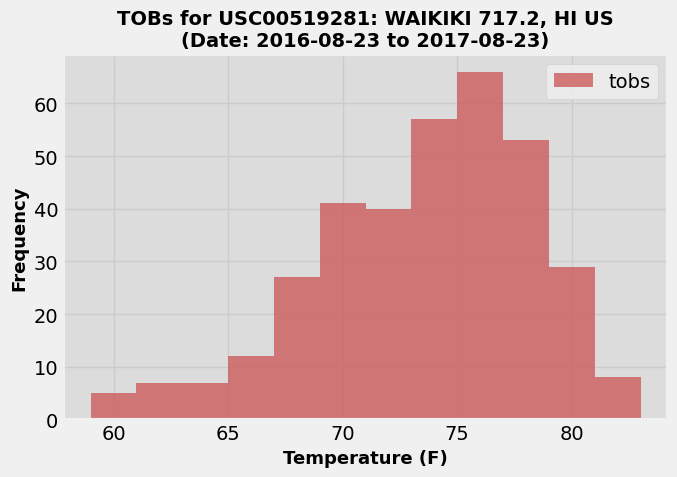

In [25]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
st_12m = session.query(Measurement.tobs)\
                    .filter(Measurement.date <= last_date_str)\
                    .filter(Measurement.date >= yr_ago_date_str)\
                    .filter(Measurement.station == most_active[0])\
                    .all()

st_12m_df = pd.DataFrame(st_12m, columns=['tobs'])

st_12m_df_plot = st_12m_df.plot.hist(bins=12, figsize=(7,5), color='indianred', alpha=0.8)

plt.title(f'TOBs for {most_active[0]}: {most_active[1]}\n(Date: {yr_ago_date_str} to {last_date_str})', fontweight = 'bold', size=14)
plt.xlabel('Temperature (F)', fontweight = 'bold', size=13)
plt.ylabel('Frequency',fontweight = 'bold', size=13)
st_12m_df_plot.set_facecolor('gainsboro')
plt.tight_layout()

plt.show()


# Close session

In [26]:
# Close Session
session.close()